# Trading Stocks with Batching and Custom Environment

In this part of the assignment, we will see how our custom environment changes the outcome of yfinance dataset of USD Bitcoin. This is to test various algorithms and find out which algorithm perforrms better in this custom environment.

In [62]:
# Gym stuff
import gym

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [63]:
import yfinance as yf

symbol = 'BTC-USD'
start_date = '1900-01-01'
end_date = '2023-08-01'

stock_data = yf.download(symbol, start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed


In [64]:
df=pd.read_csv('./data/batch (0).csv')
df=pd.DataFrame(data=df,columns=['Open','High','Low','Close','Volume'])
print("Data Types\n",df.dtypes)
print("\nShape of the dataset",df.shape)

Data Types
 Open      float64
High      float64
Low       float64
Close     float64
Volume     object
dtype: object

Shape of the dataset (24, 5)


In [65]:
df=pd.DataFrame(data=df,columns=['Open','High','Low','Close','Volume'])
df.head()

,Open,High,Low,Close,Volume
0,275.00,295.50,262.27,264.5,"25,845,900"
1,241.64,281.50,232.60,260.0,"28,312,490"
2,269.43,348.50,172.00,265.0,"71,570,570"
3,217.71,249.85,208.51,246.9,"39,099,328"
4,154.89,210.87,146.10,194.5,"63,565,621"


In [66]:
from time import time
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym

# Discrete set of 2 actions, buying and selling.
class Actions(Enum):
    Sell = 0
    Buy = 1

# Shorting stock: Profiting from a stock's decline by selling borrowed shares, aiming to buy them back at a lower price.
# Longing stock: Profiting from a stock's rise by buying and holding shares, with the expectation of selling them at a higher price.

class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

# creating custom environment
class TradingEnv(gym.Env):

    metadata = {'render_modes': ['human'], 'render_fps': 3}

    def __init__(self, df, window_size, render_mode=None):
        assert df.ndim == 2
        assert render_mode is None or render_mode in self.metadata['render_modes']

        self.render_mode = render_mode

        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = gym.spaces.Discrete(len(Actions))
        INF = 1e10
        self.observation_space = gym.spaces.Box(
            low=-INF, high=INF, shape=self.shape, dtype=np.float32,
        )

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._truncated = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        self.action_space.seed(int((self.np_random.uniform(0, seed if seed is not None else 1))))

        self._truncated = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}

        observation = self._get_observation()
        info = self._get_info()

        if self.render_mode == 'human':
            self._render_frame()

        return observation, info

    def step(self, action):
        self._truncated = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._truncated = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade:
            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = self._get_info()
        self._update_history(info)

        if self.render_mode == 'human':
            self._render_frame()

        return observation, step_reward, False, self._truncated, info

    def _get_info(self):
        return dict(
            total_reward=self._total_reward,
            total_profit=self._total_profit,
            position=self._position
        )

    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    def _render_frame(self):
        self.render()

    def render(self, mode='human'):
        # Red shows shorting of stock and Green shows Longing of the stock.
        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        start_time = time()

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("Total Reward: %.6f" % self._total_reward)
        print("Total Profit: %.6f" % self._total_profit)

        end_time = time()
        process_time = end_time - start_time

        pause_time = (1 / self.metadata['render_fps']) - process_time
        assert pause_time > 0., "High FPS! Try to reduce the 'render_fps' value."

        plt.pause(pause_time)

    def render_all(self, title=None):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        if title:
            plt.title(title)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

    def close(self):
        plt.close()

    def save_rendering(self, filepath):
        plt.savefig(filepath)

    def pause_rendering(self):
        plt.show()

    def _process_data(self):
        raise NotImplementedError

    def _calculate_reward(self, action):
        raise NotImplementedError

    def _update_profit(self, action):
        raise NotImplementedError

    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError

# Reward Function, Total Reward and finding Maximum Possible Reward

In [67]:
import numpy as np
# Customizing the environment. 
class StocksEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound, render_mode=None):
        assert len(frame_bound) == 2

        self.frame_bound = frame_bound
        super().__init__(df, window_size, render_mode)

        self.trade_fee_bid_percent = 0.01  # unit
        self.trade_fee_ask_percent = 0.005  # unit

    def _process_data(self):
        prices = self.df.loc[:, 'Close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices.astype(np.float32), signal_features.astype(np.float32)
    
    # Reward function where we buy if shoring and sell when longing. 
    # This code calculates the reward for a trading step, initializing step_reward to zero.
    #  It checks if the specified action corresponds to a valid trade (buying in a short position or selling in a long position),
    #  and if so, it computes the price difference and adds it to the reward only if the agent is in a long position. 
    # The final reward value is returned.
    def _calculate_reward(self, action):
        step_reward = 0

        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price

            if self._position == Positions.Long:
                step_reward += price_diff

        return step_reward
        
    def _update_profit(self, action):
        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade or self._truncated:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
                self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price
    # This code iterates through price data and simulates a simple trading strategy.
    #  It initializes calculates profits by buying low and selling high, and updates the variables accordingly. 
    # The final profit value is returned after the iteration.
    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            if position == Positions.Long:
                current_price = self.prices[current_tick - 1]
                last_trade_price = self.prices[last_trade_tick]
                shares = profit / last_trade_price
                profit = shares * current_price
            last_trade_tick = current_tick - 1

        return profit

In [68]:
import gymnasium as gym

# Creating the Custom Environment

In [69]:
env = StocksEnv(df=df,window_size=5,frame_bound=(5,100))

In [70]:
print("Environment information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

Environment information:
> shape: (5, 2)
> df.shape: (24, 5)
> prices.shape: (24,)
> signal_features.shape: (24, 2)
> max_possible_profit: 1.7180403655552337


In [71]:
# Showing progress in the graph showing total reward and total profit
def showProgress():
    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.show()

Importing the policies 

In [72]:
from stable_baselines3 import A2C
from stable_baselines3 import DQN
from stable_baselines3 import PPO

# Batching the data

(24, 5)


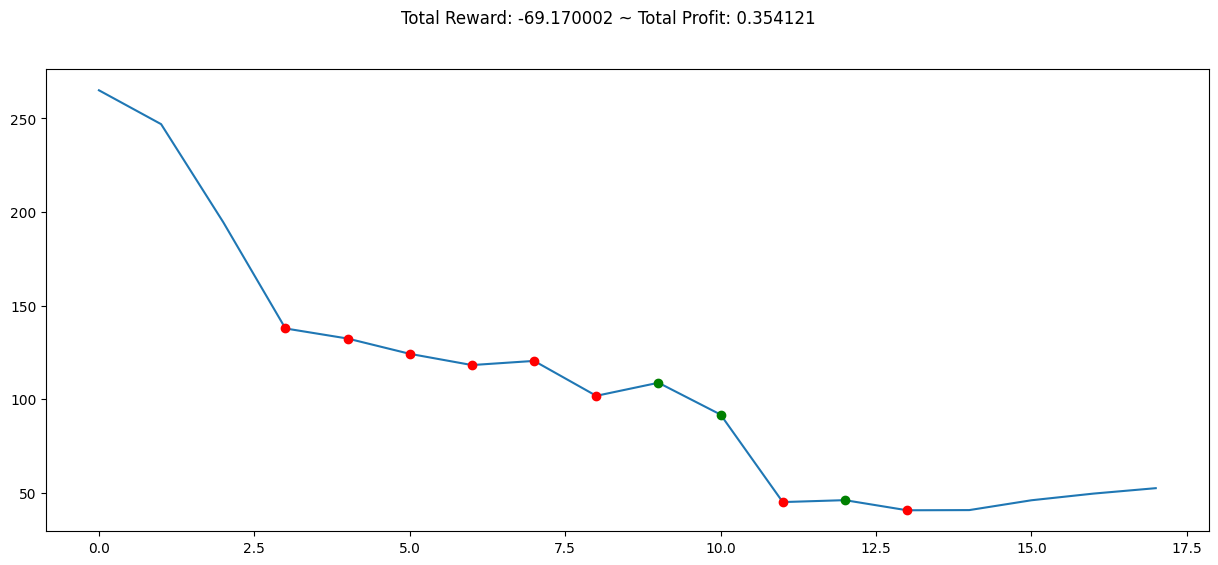

Learning finished for batch (0)
(24, 5)


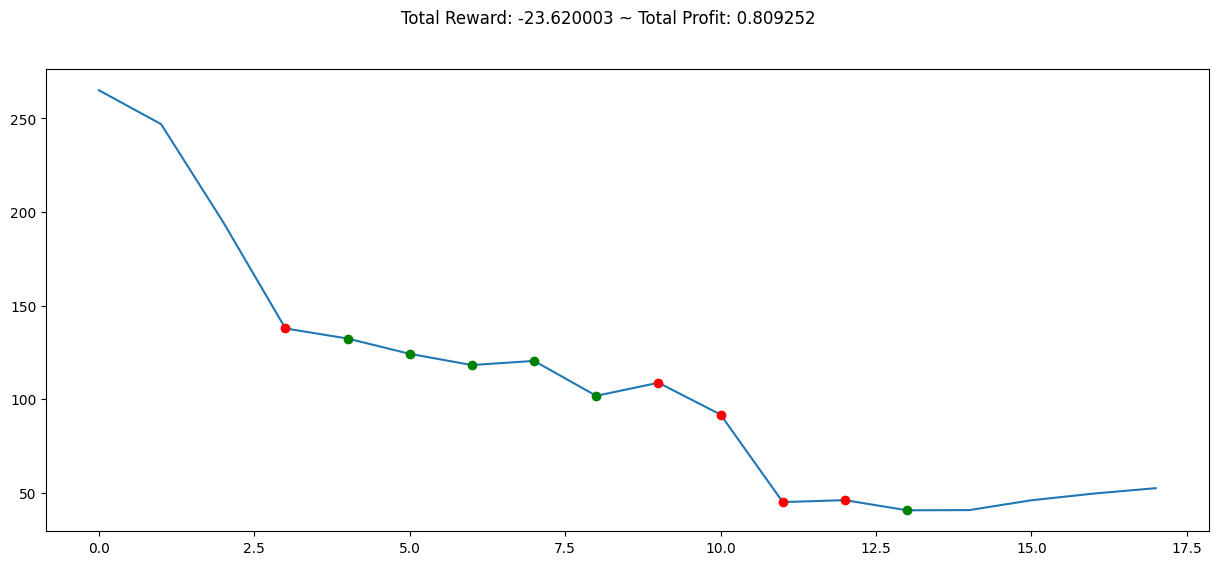

Learning finished for batch (1)
(24, 5)


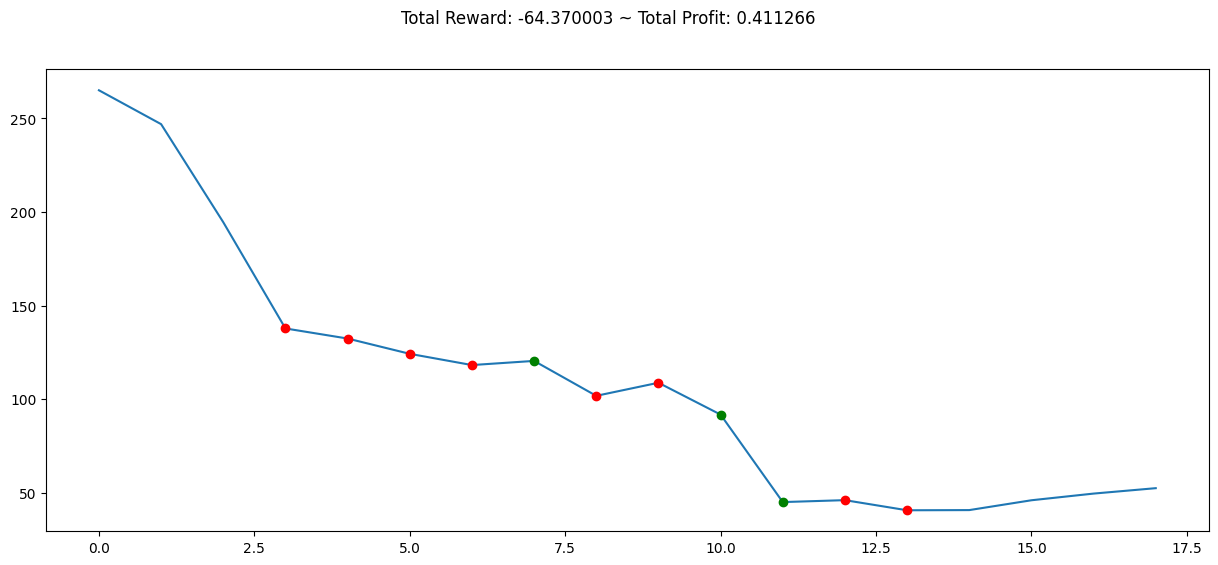

Learning finished for batch (2)
(24, 5)


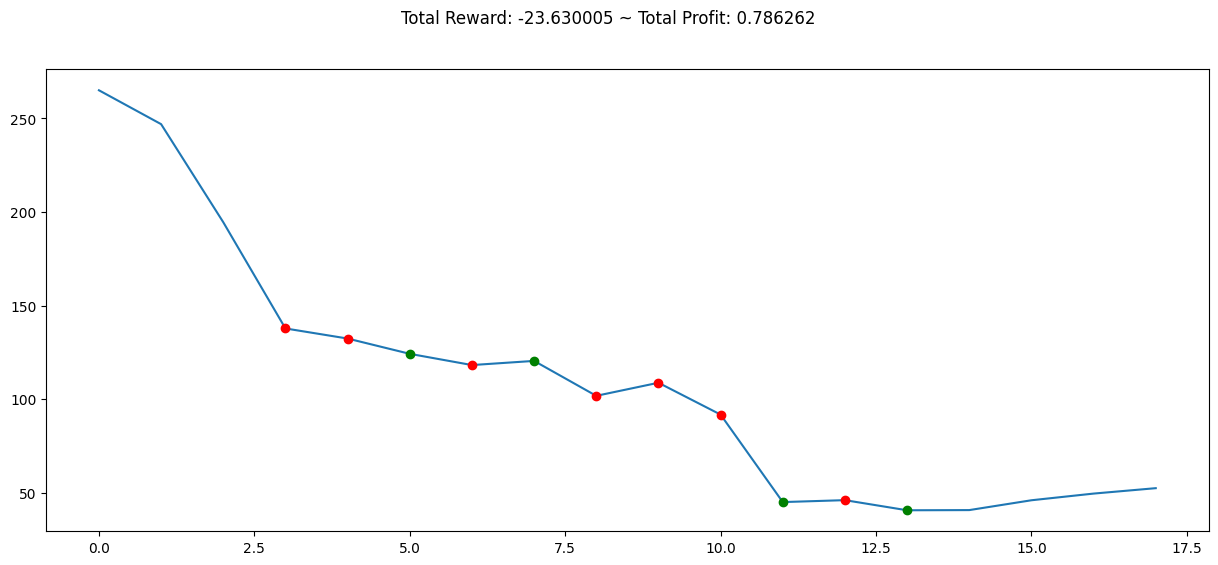

Learning finished for batch (3)
(24, 5)


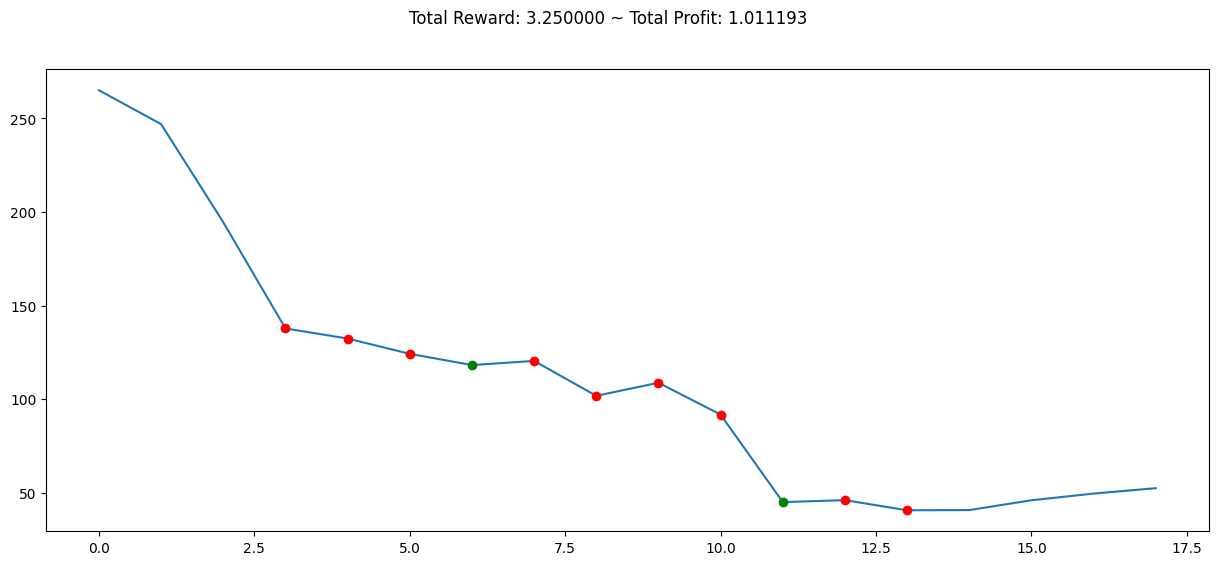

Learning finished for batch (4)
(24, 5)


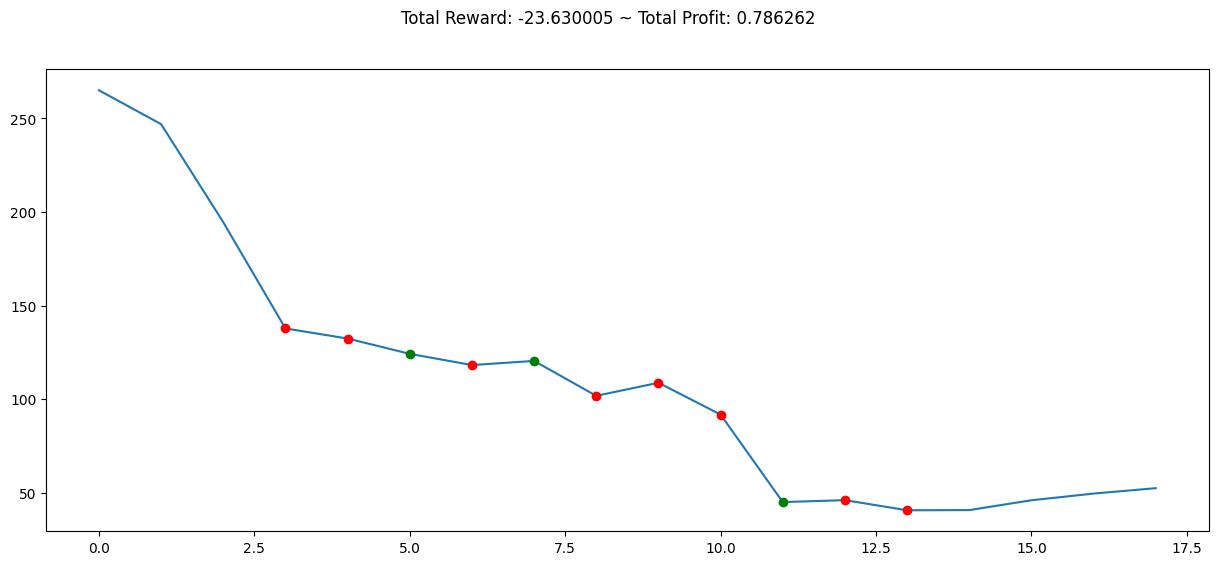

Learning finished for batch (5)
(25, 5)


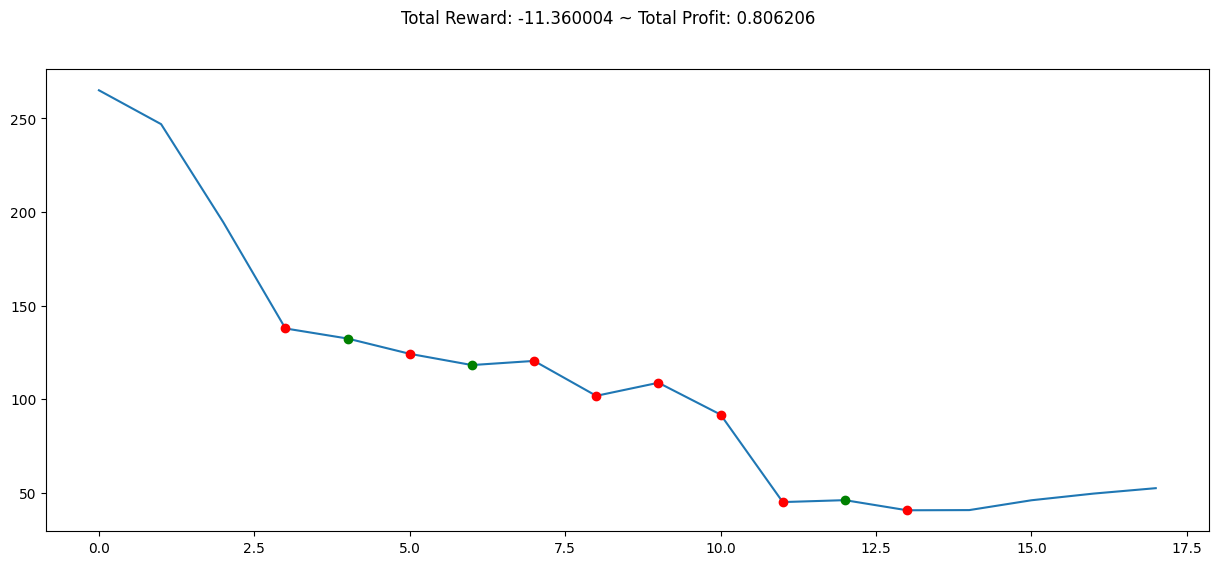

Learning finished for batch (6)
(24, 5)


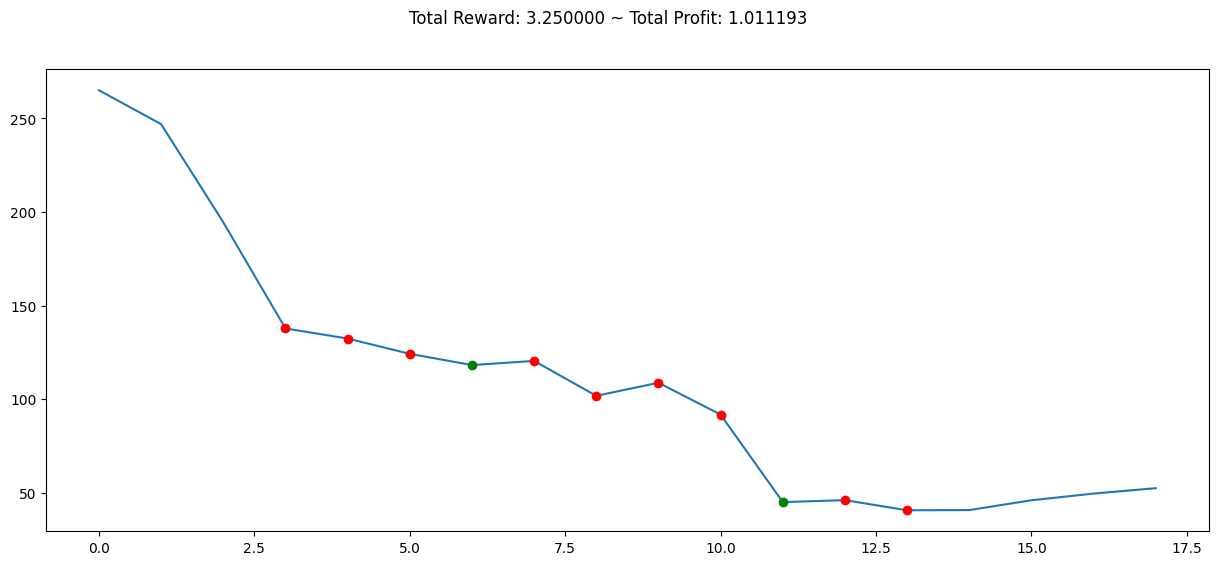

Learning finished for batch (7)
(24, 5)


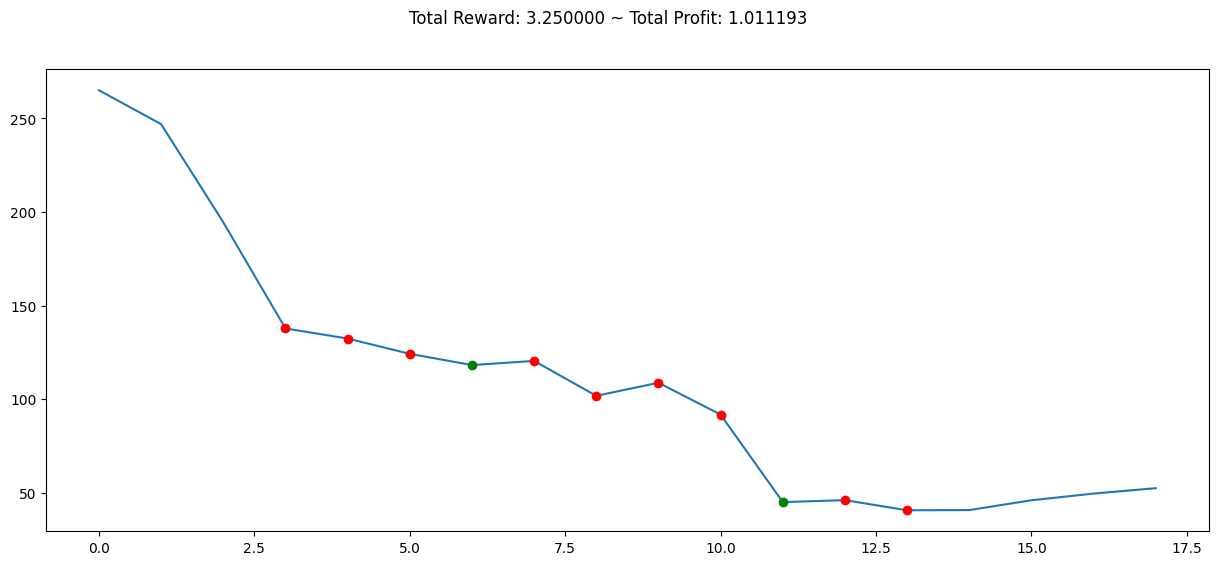

Learning finished for batch (8)
(24, 5)


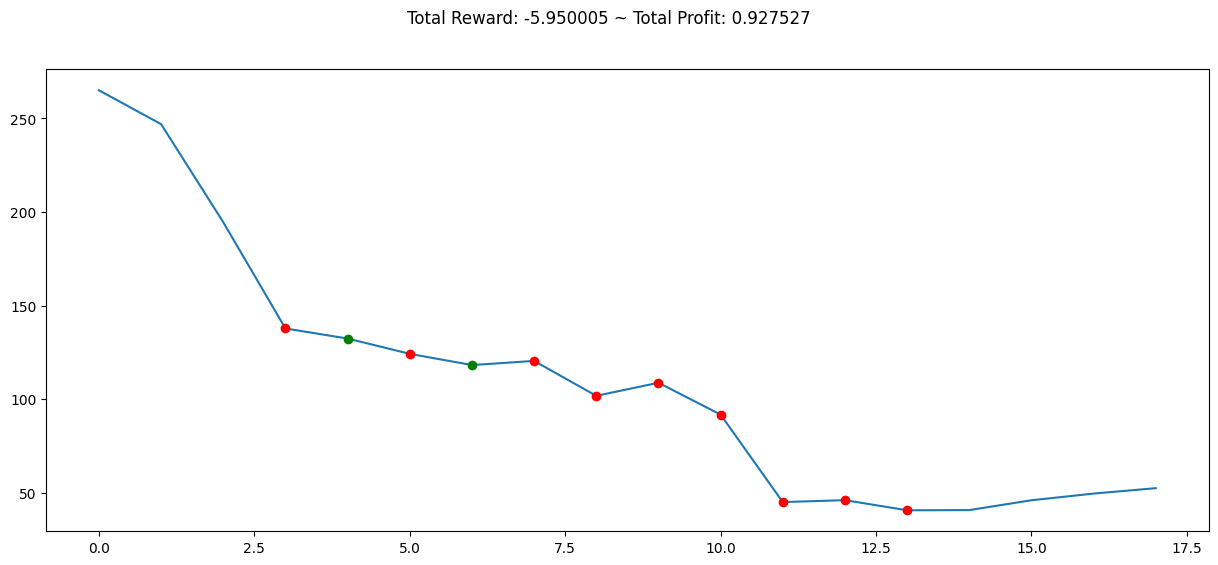

Learning finished for batch (9)
Maximum Reward Obtained was 3


In [77]:
# Create the initial model outside the loop
initial_df = pd.read_csv('./data/batch (0).csv')
initial_df = pd.DataFrame(data=initial_df, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
env = StocksEnv(df=initial_df, window_size=3, frame_bound=(5,20))
a2cModel = A2C("MlpPolicy", env)
maxReward=-99999
for i in range(10):
    df = pd.read_csv('./data/batch (%d).csv' % i)
    df = pd.DataFrame(data=df, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
    print(df.shape)
    env.df = df
    a2cModel.learn(total_timesteps=10)
    # if total reward isn't exactly 1 (no buy / no sell)
    if(env._total_profit != 1):
        showProgress()
    maxReward=max(maxReward,env._total_reward)
    print("Learning finished for batch (%d)" % i)
print("Maximum Reward Obtained was %d"%maxReward)

(24, 5)
Learning finished for batch (0)
(24, 5)


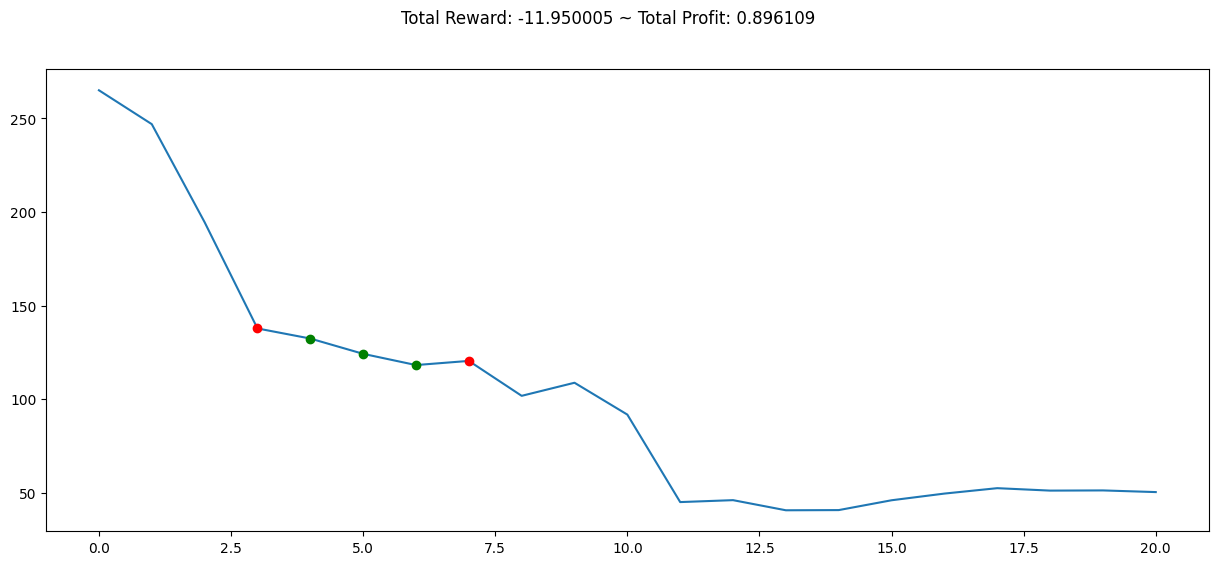

Learning finished for batch (1)
(24, 5)


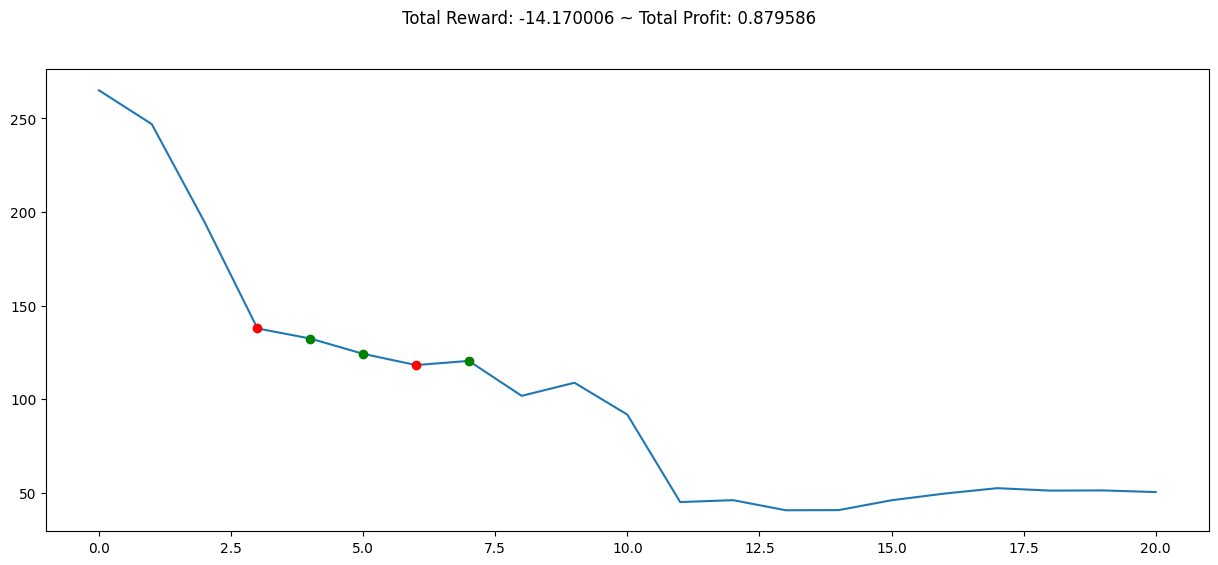

Learning finished for batch (2)
(24, 5)
Learning finished for batch (3)
(24, 5)


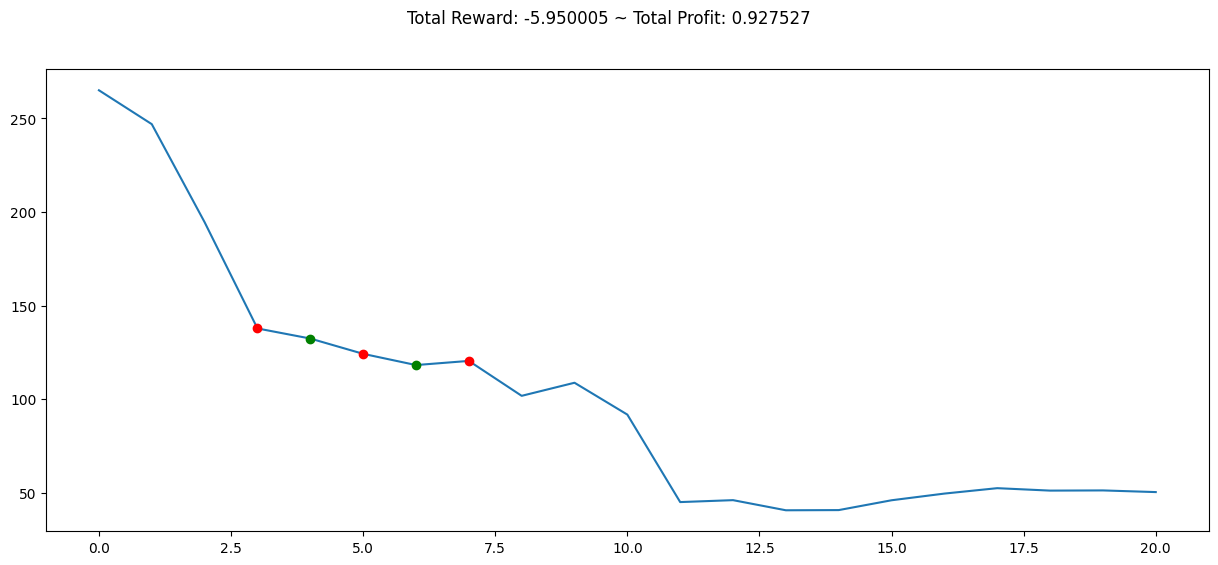

Learning finished for batch (4)
(24, 5)


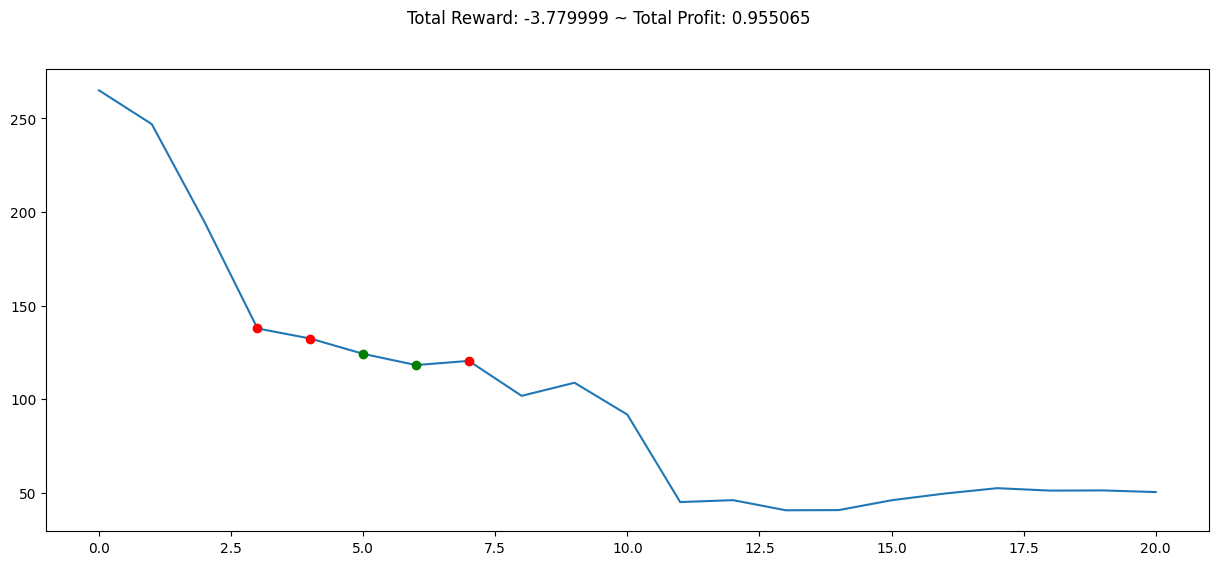

Learning finished for batch (5)
(25, 5)
Learning finished for batch (6)
(24, 5)


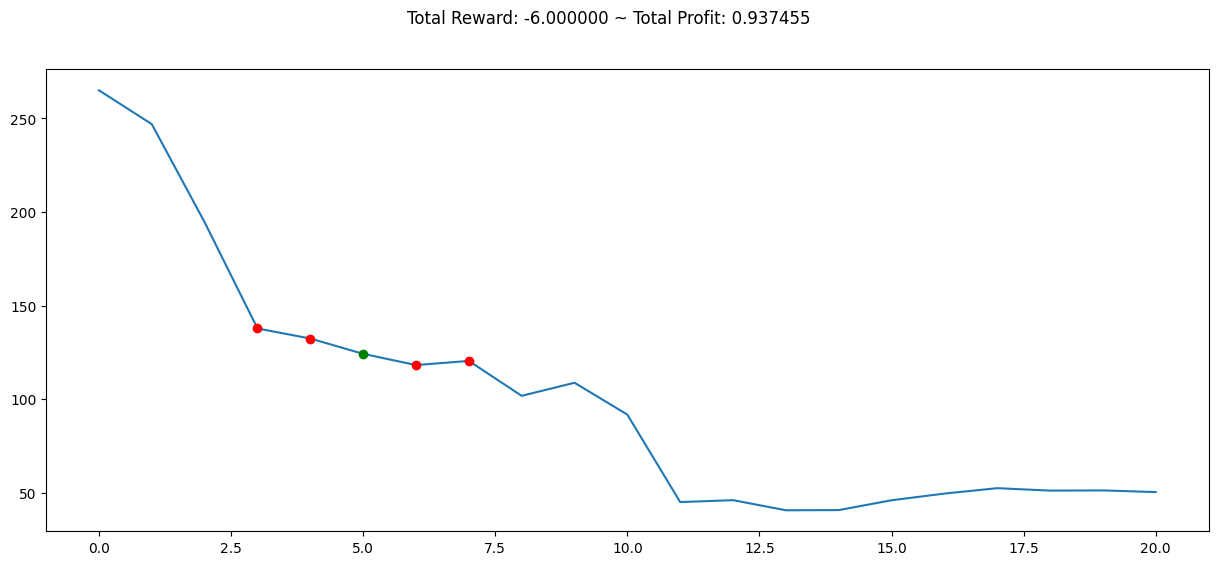

Learning finished for batch (7)
(24, 5)
Learning finished for batch (8)
(24, 5)


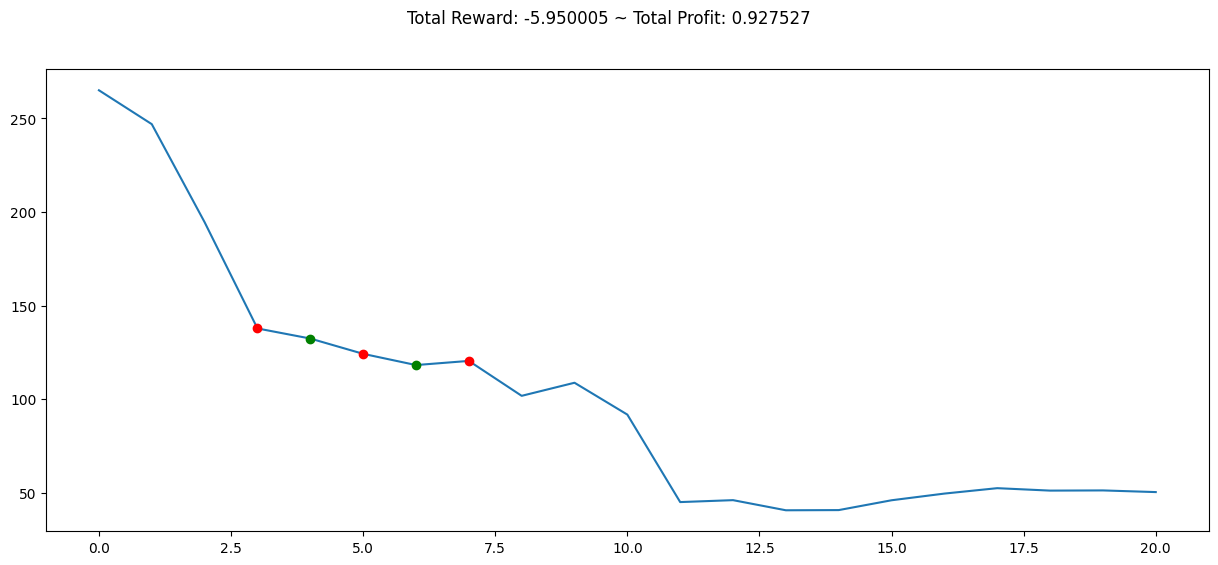

Learning finished for batch (9)
Maximum Reward Obtained was -3


In [81]:
# Create the initial model outside the loop
maxReward=-9999
initial_df = pd.read_csv('./data/batch (0).csv')
initial_df = pd.DataFrame(data=initial_df, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
env = StocksEnv(df=initial_df, window_size=3, frame_bound=(5,23))
dqnModel = DQN("MlpPolicy", env)
dqnModel.save("dqn")
for i in range(10):
    dqnModel = DQN.load("dqn", env=env)
    df = pd.read_csv('./data/batch (%d).csv' % i)
    df = pd.DataFrame(data=df, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
    print(df.shape)
    env.df = df
    dqnModel.learn(total_timesteps=10000)
    dqnModel.save("dqn")
    # if total reward isn't exactly 1 (no buy / no sell)
    if(env._total_profit != 1):
        maxReward=max(env._total_reward,maxReward)
        showProgress()
    print("Learning finished for batch (%d)" % i)
    del dqnModel
print("Maximum Reward Obtained was %d"%maxReward)

(24, 5)


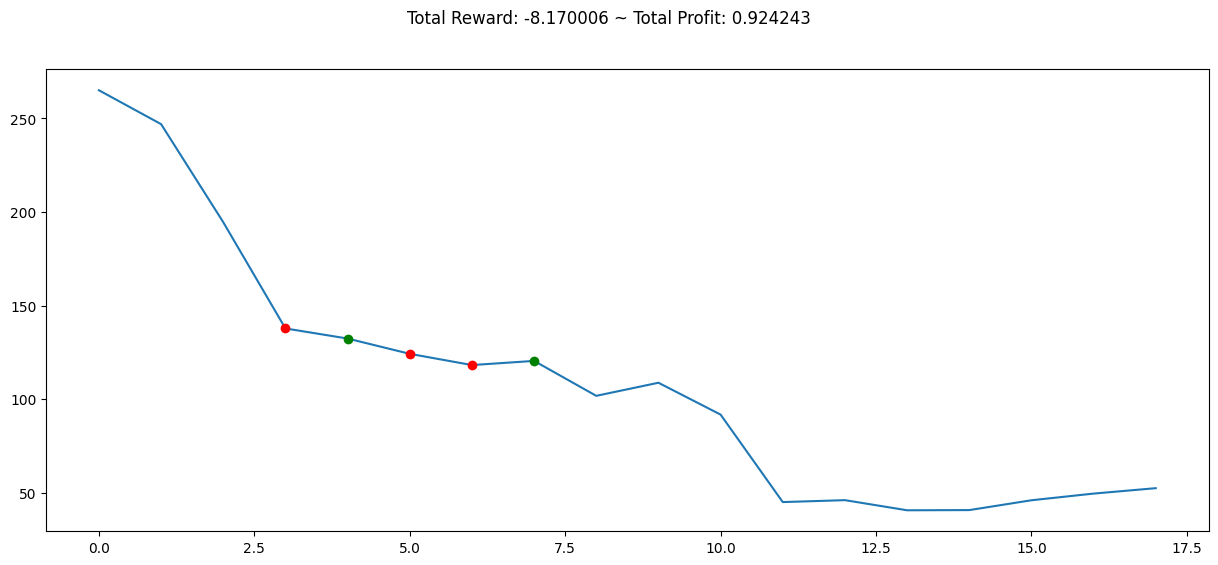

Learning finished for batch (0)
(24, 5)


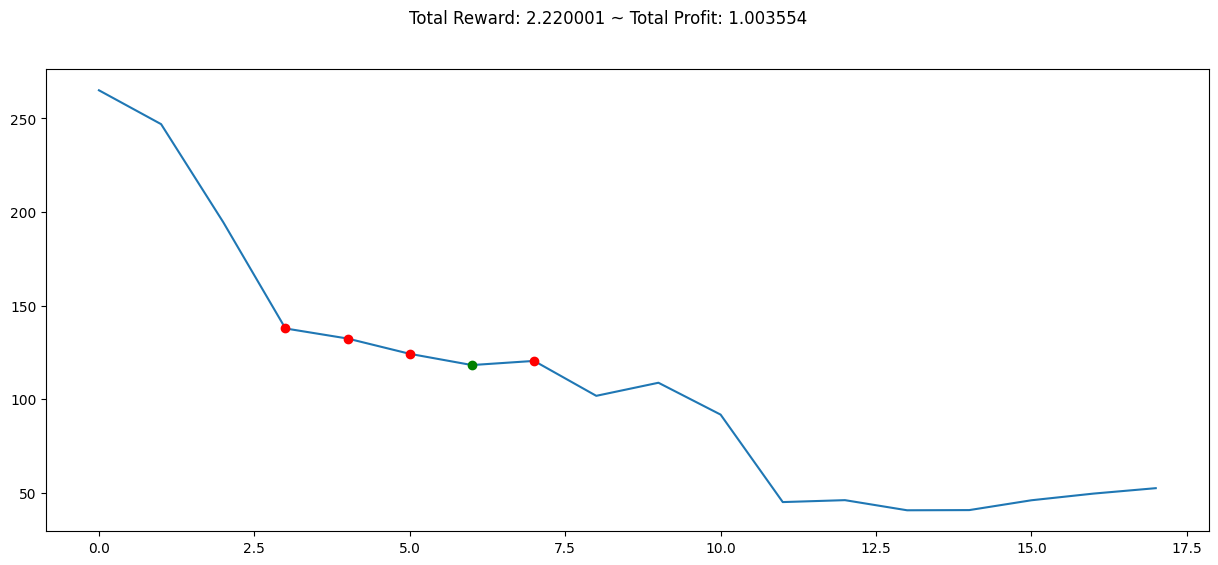

Learning finished for batch (1)
(24, 5)


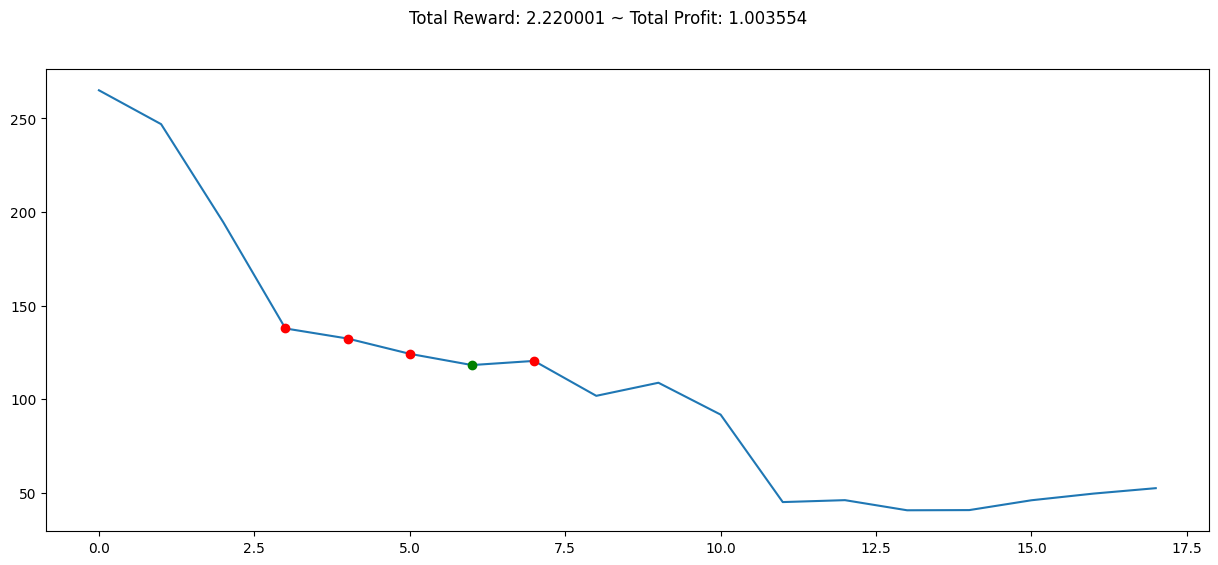

Learning finished for batch (2)
(24, 5)


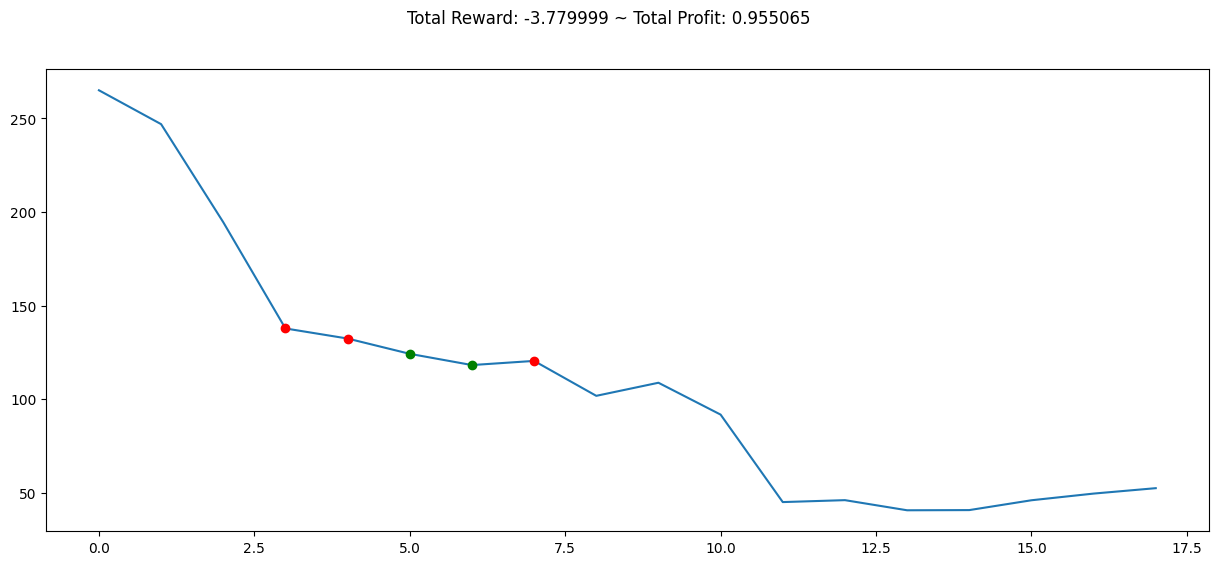

Learning finished for batch (3)
(24, 5)


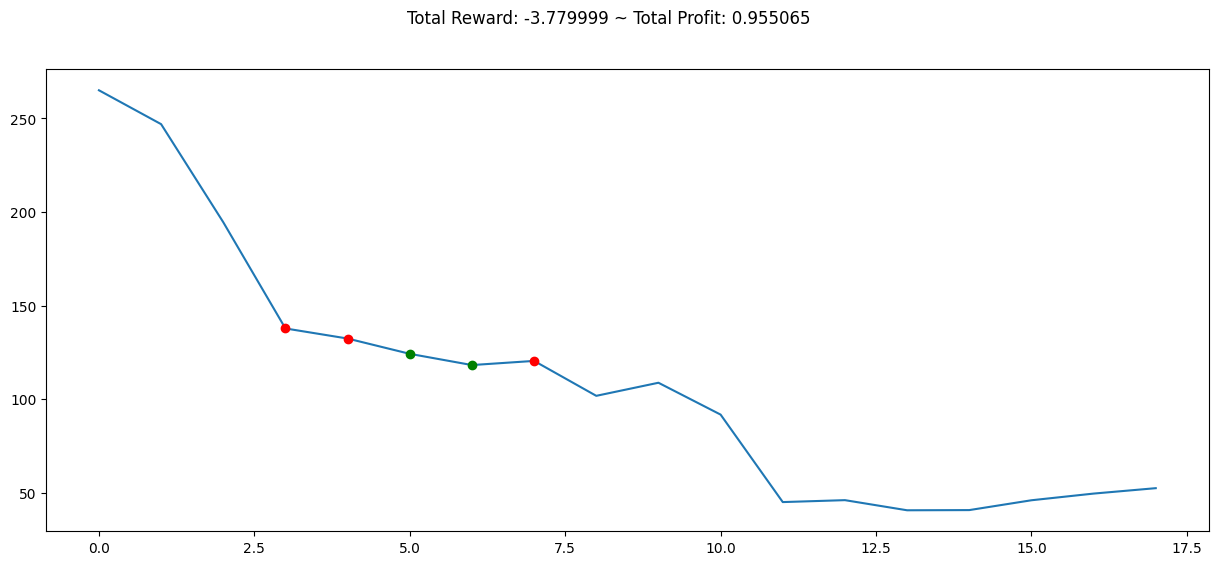

Learning finished for batch (4)
(24, 5)
Learning finished for batch (5)
(25, 5)


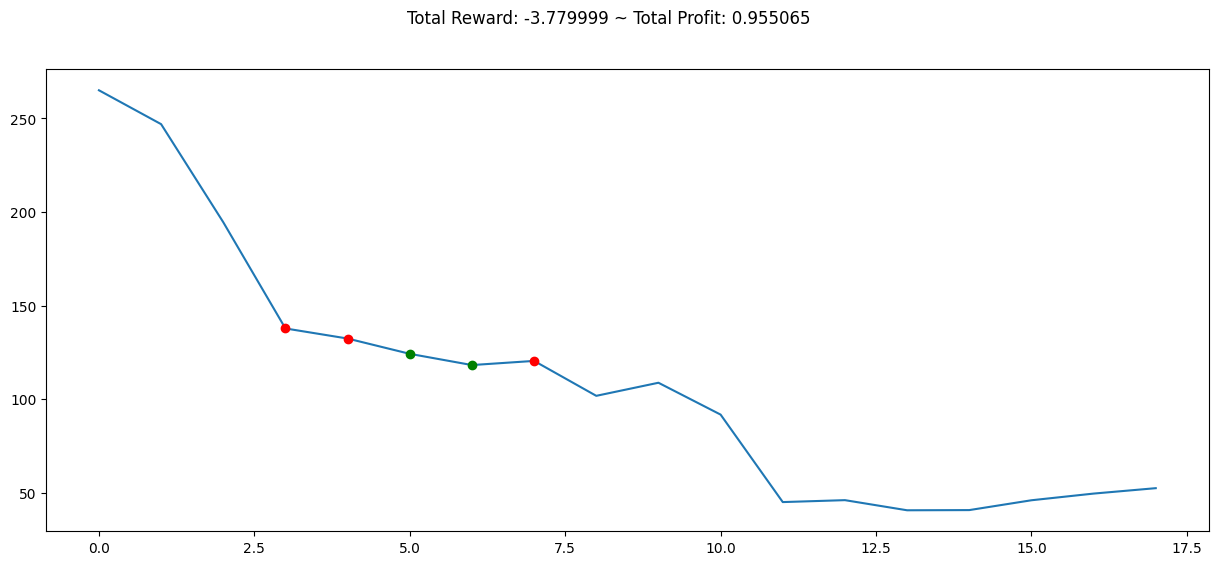

Learning finished for batch (6)
(24, 5)
Learning finished for batch (7)
(24, 5)


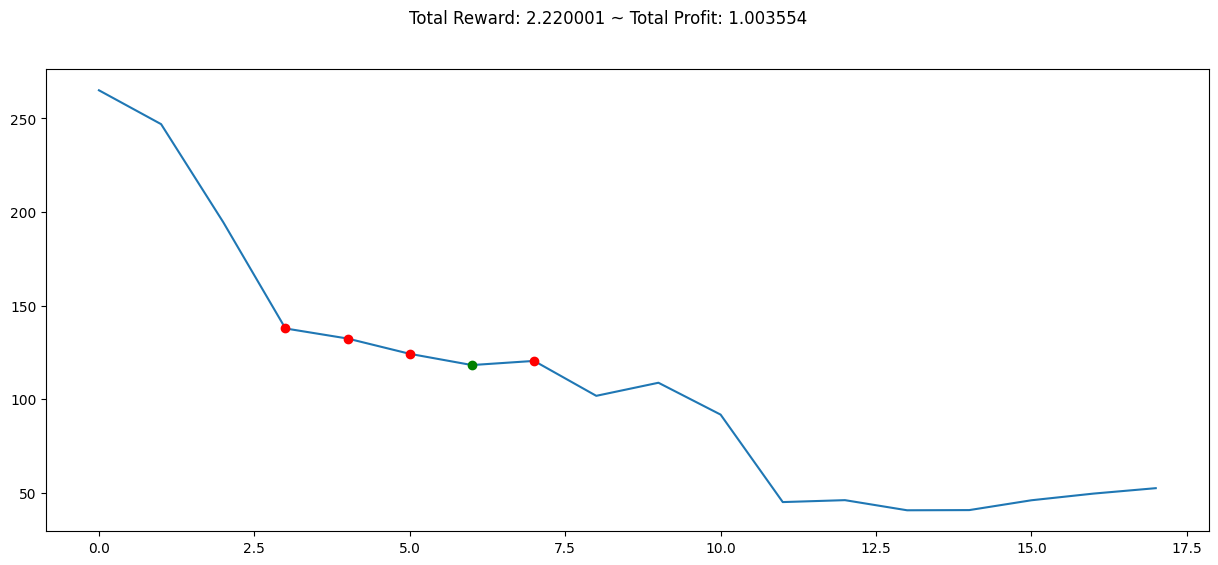

Learning finished for batch (8)
(24, 5)


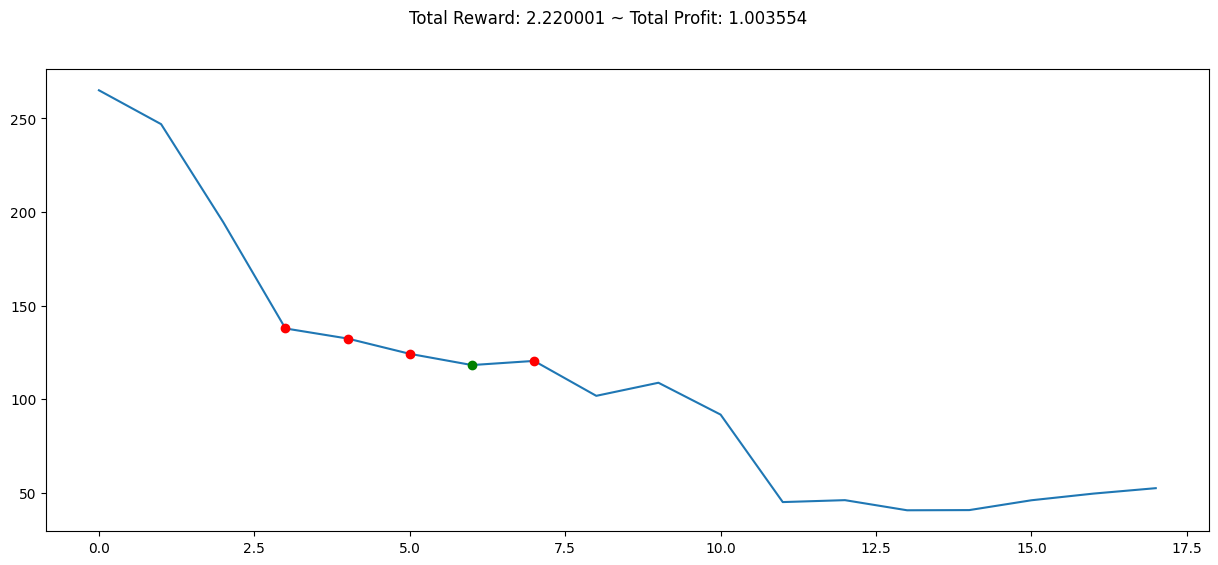

Learning finished for batch (9)
Maximum Reward Obtained was 2


In [88]:
# Create the initial model outside the loop
initial_df = pd.read_csv('./data/batch (0).csv')
maxReward=-9999
initial_df = pd.DataFrame(data=initial_df, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
env = StocksEnv(df=initial_df, window_size=3, frame_bound=(5,20))
ppoModel = PPO("MlpPolicy", env)

for i in range(10):
    df = pd.read_csv('./data/batch (%d).csv' % i)
    df = pd.DataFrame(data=df, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
    print(df.shape)
    env.df = df
    ppoModel.learn(total_timesteps=100)
    maxReward = max(maxReward, env._total_reward)
    ppoModel.save("ppo")
    # if total reward isn't exactly 1 (no buy / no sell)
    if(env._total_profit != 1):
        showProgress()
    print("Learning finished for batch (%d)" % i)
print("Maximum Reward Obtained was %d"%maxReward)

(24, 5)


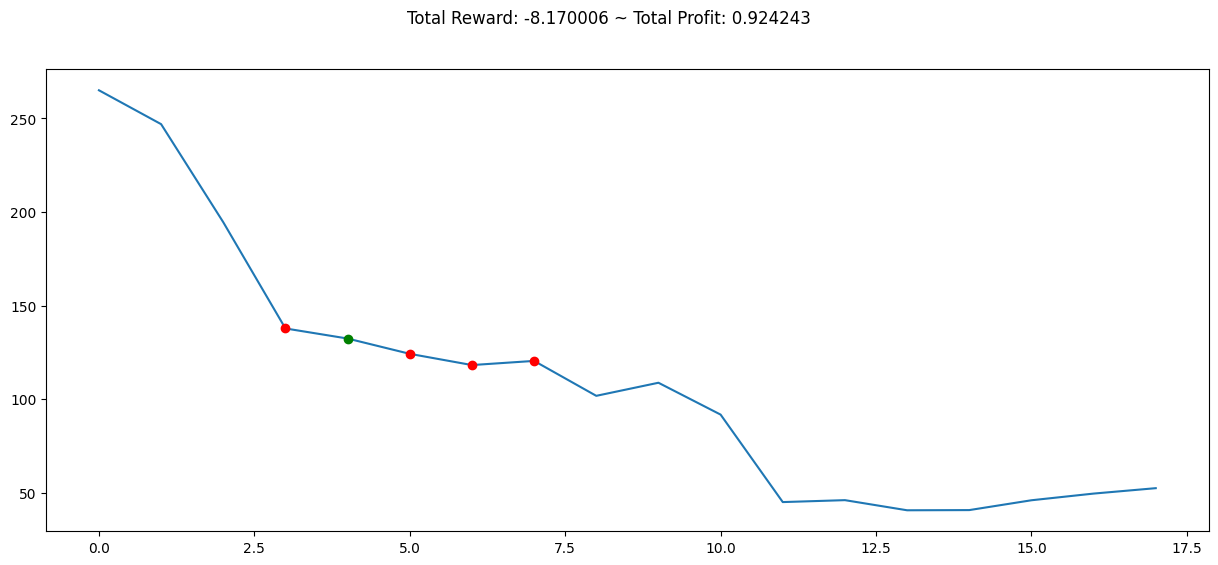

Learning finished for batch (0)
(24, 5)


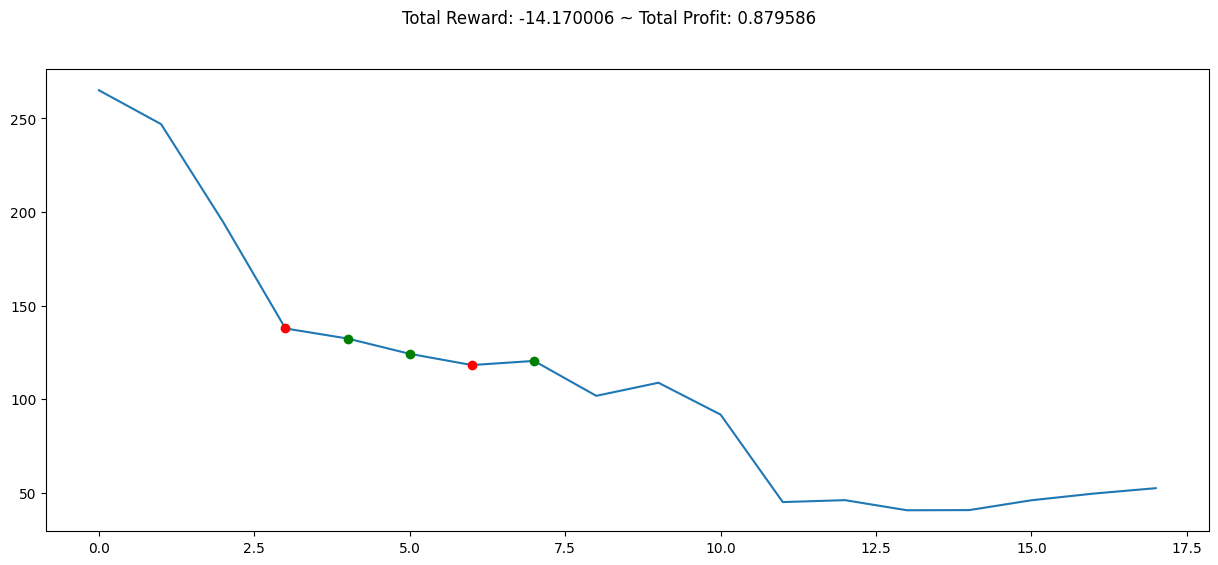

Learning finished for batch (1)
(24, 5)


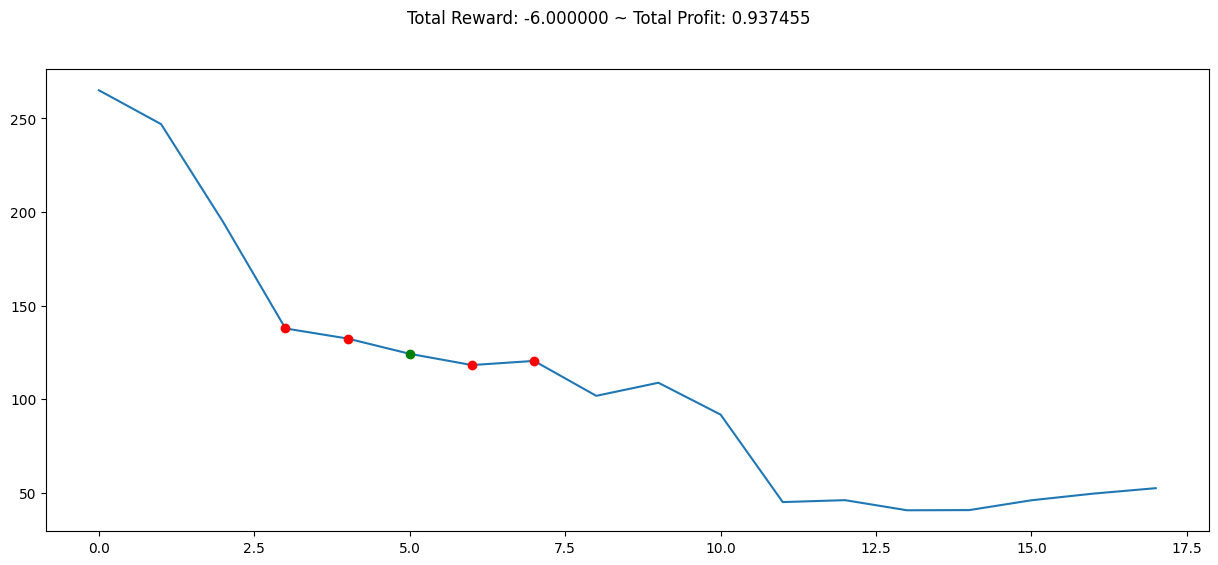

Learning finished for batch (2)
(24, 5)


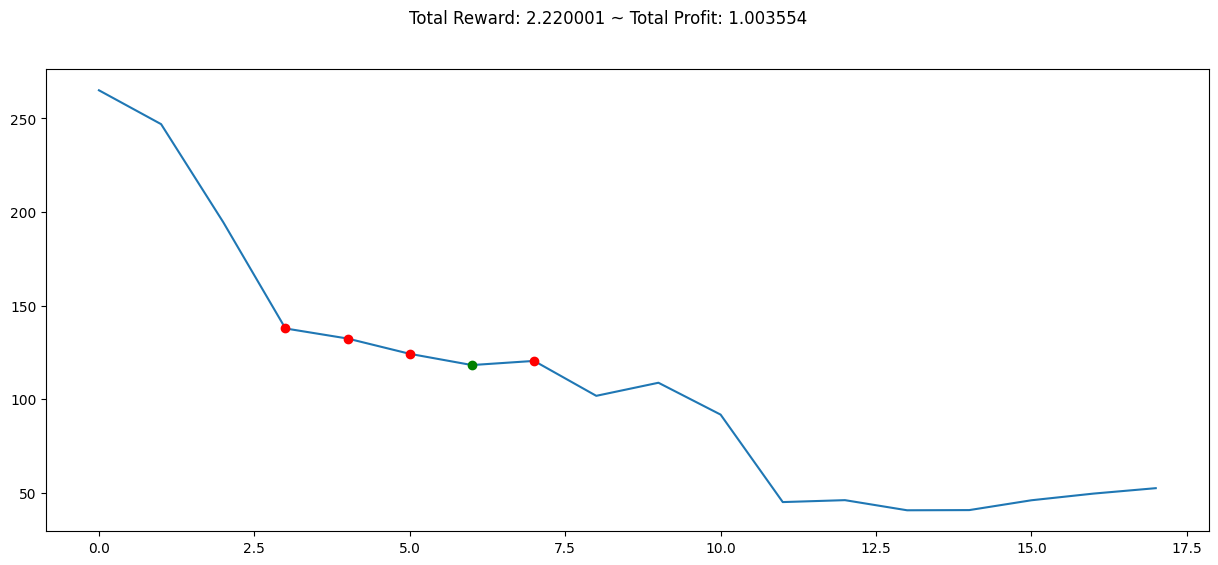

Learning finished for batch (3)
(24, 5)


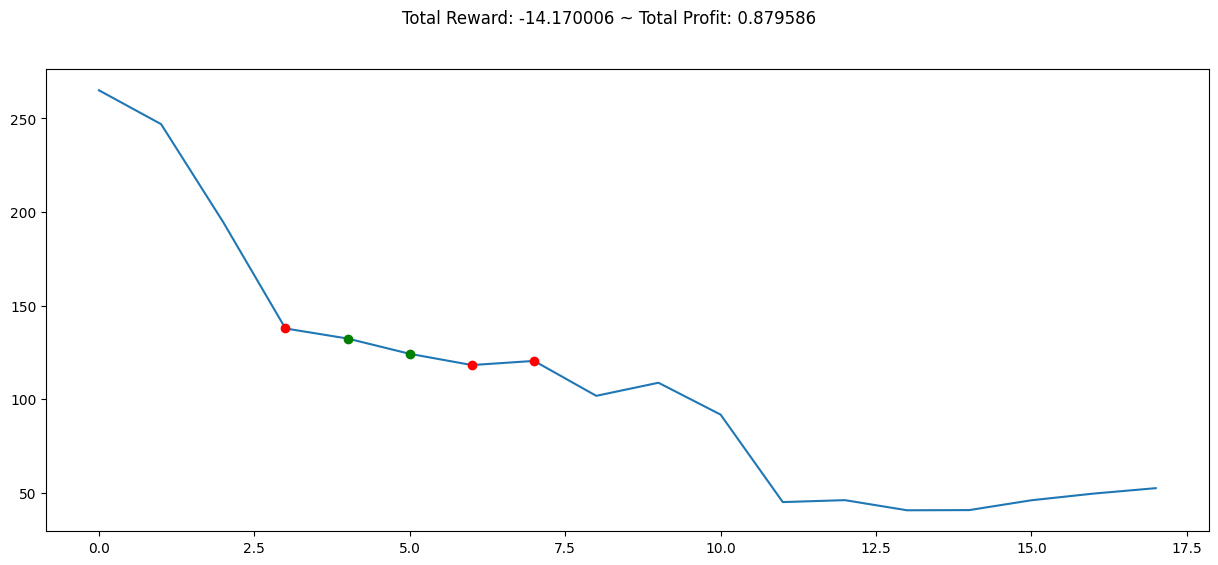

Learning finished for batch (4)
(24, 5)


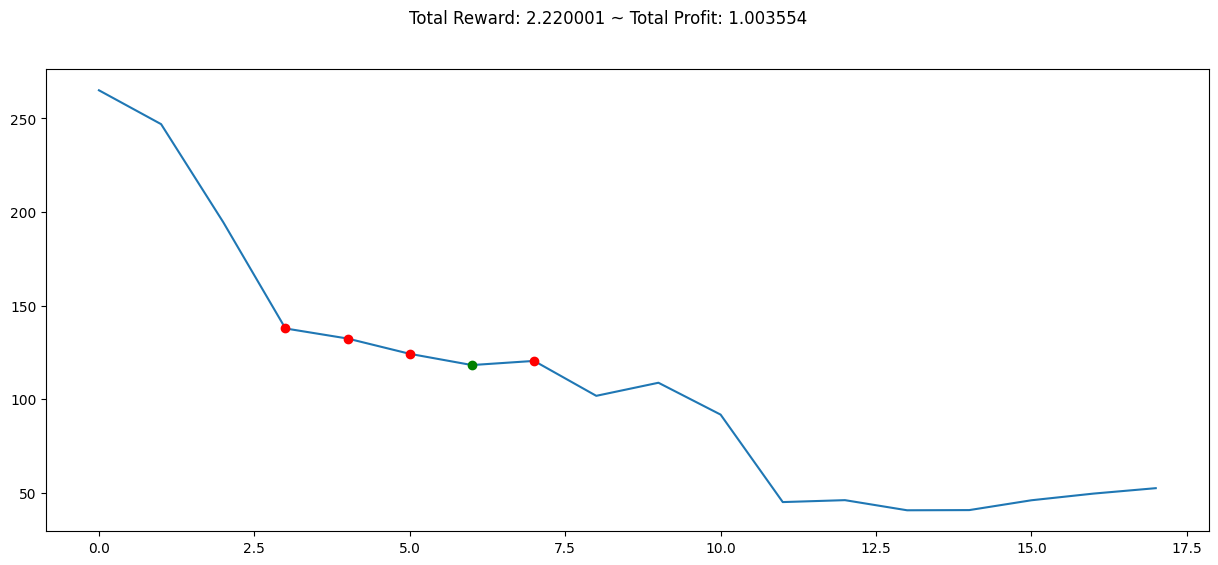

Learning finished for batch (5)
(25, 5)


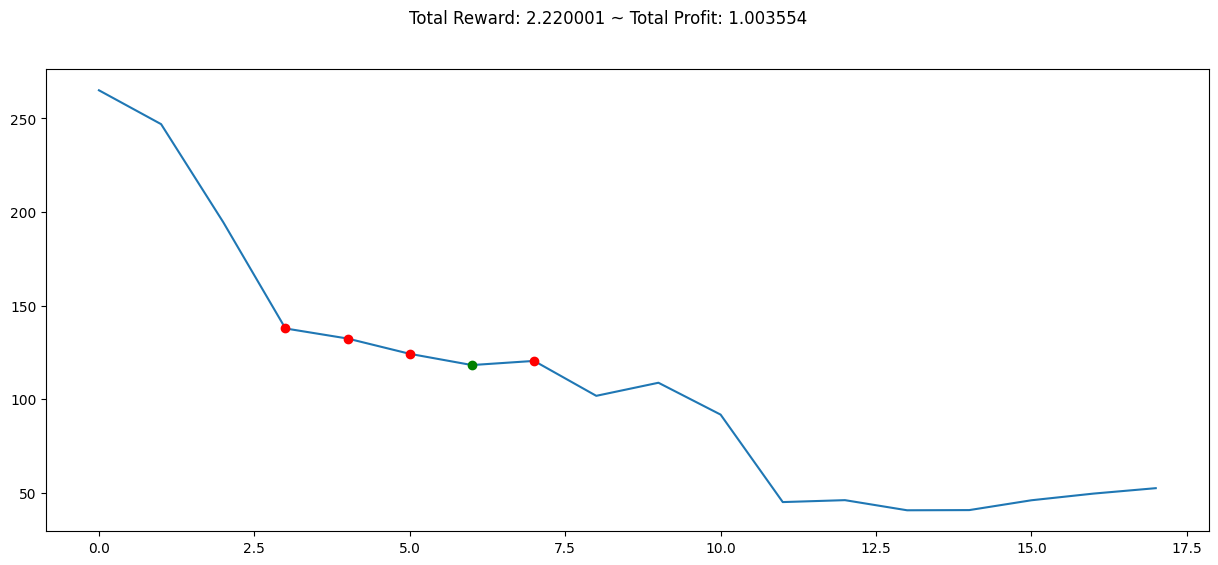

Learning finished for batch (6)
(24, 5)


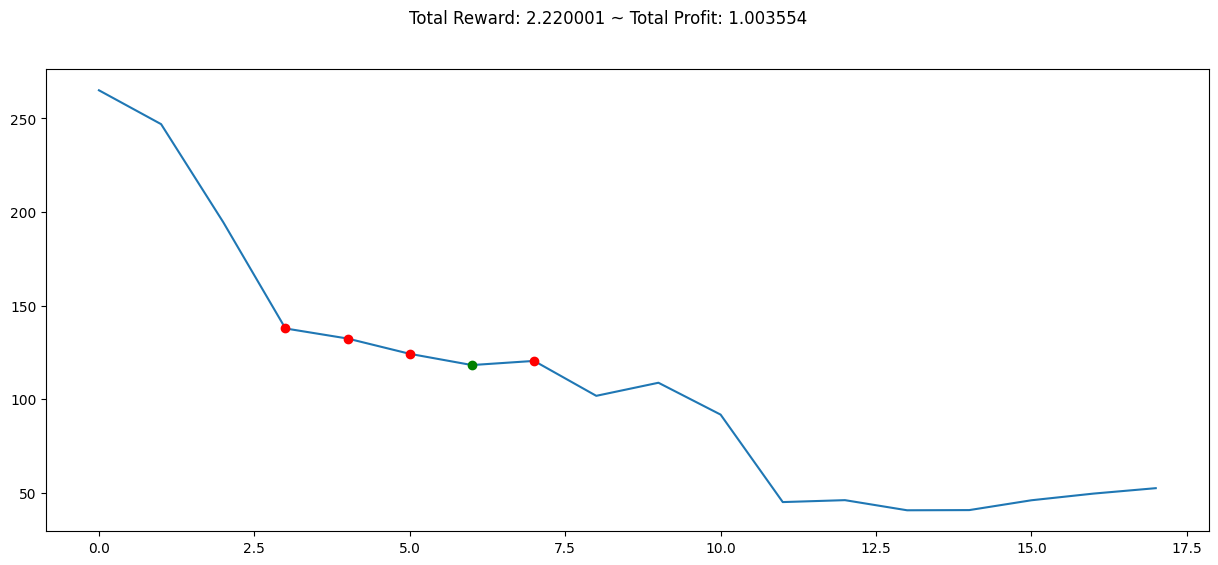

Learning finished for batch (7)
(24, 5)


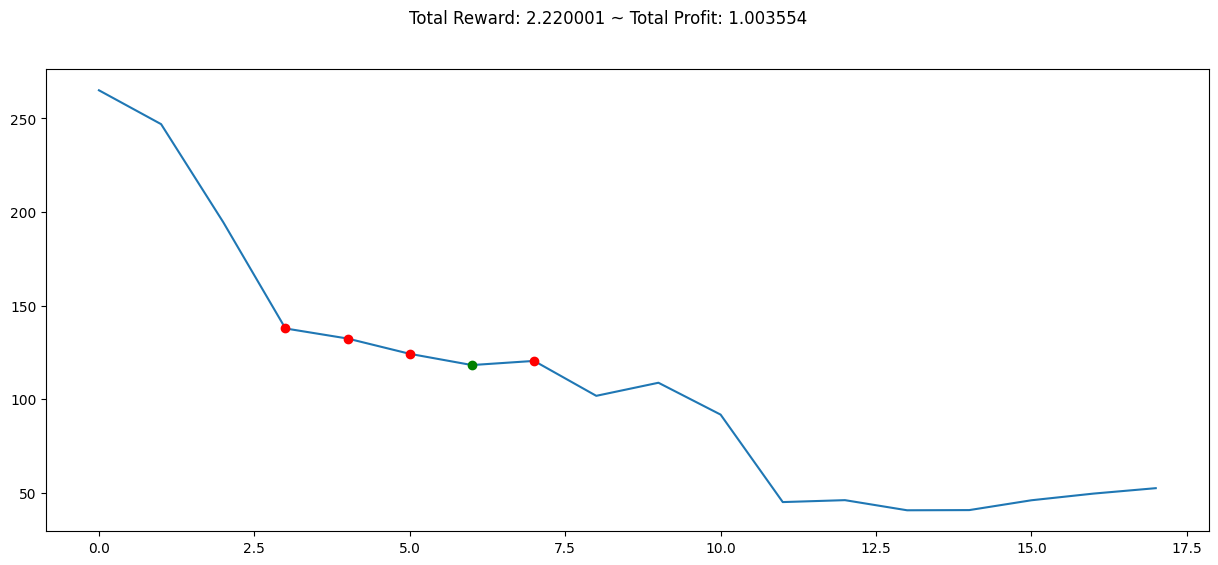

Learning finished for batch (8)
(24, 5)


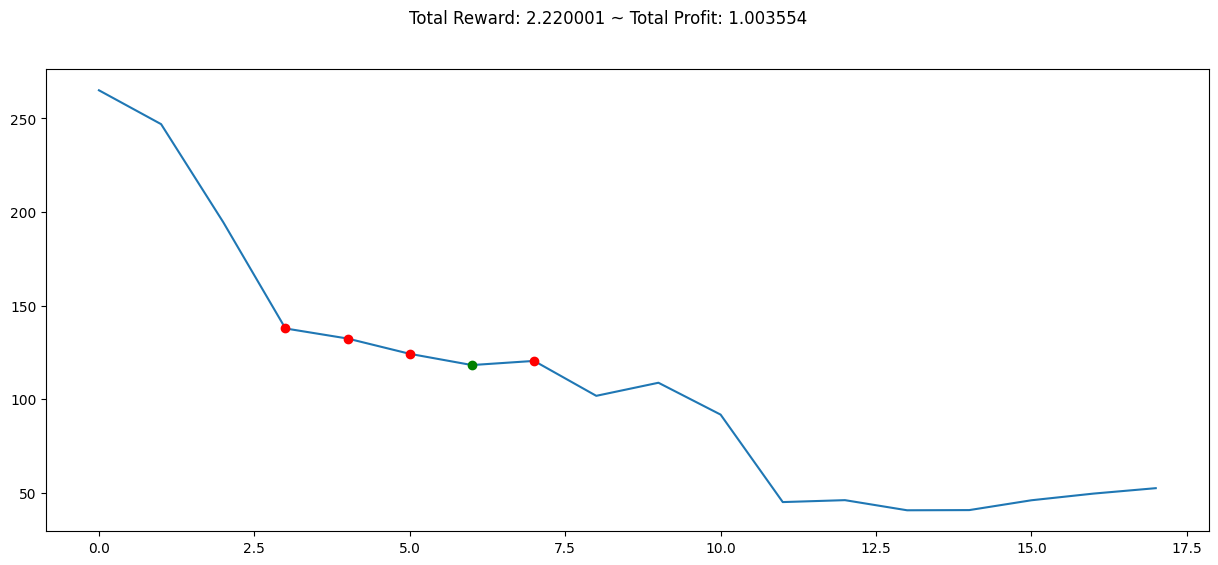

Learning finished for batch (9)
Maximum Reward Obtained was 2


In [89]:
# Create the initial model outside the loop
initial_df = pd.read_csv('./data/batch (0).csv')
maxReward=-9999
initial_df = pd.DataFrame(data=initial_df, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
env = StocksEnv(df=initial_df, window_size=3, frame_bound=(5,20))
ppoModel = PPO("MlpPolicy", env)
ppoModel.save("ppo")
for i in range(10):
    ppoModel = PPO.load("ppo", env=env)
    df = pd.read_csv('./data/batch (%d).csv' % i)
    df = pd.DataFrame(data=df, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
    print(df.shape)
    env.df = df
    ppoModel.learn(total_timesteps=100)
    maxReward = max(maxReward, env._total_reward)
    ppoModel.save("ppo")
    # if total reward isn't exactly 1 (no buy / no sell)
    if(env._total_profit != 1):
        showProgress()
    print("Learning finished for batch (%d)" % i)
    del ppoModel
print("Maximum Reward Obtained was %d"%maxReward)

## The following are the results of training a model on various sets of algorithms.

### 1. DQN algorithm stops after a few iterations and gives similar results. This can be due to insufficient exploration or neural network architecture.
### 2. A2C performs very well hitting a record high of profit and shows promising results.
### 3. PPO also performs well but faces similar issue as with DQN algorithm. 

| Algorithm | Maximum Reward Obtained | Maxium Total Profit |
| --------------- | --------------- | --------------- |
| Advantage Actor-Critic (A2C)    |3.250000    | 1.011193   |
| Deep Q-Learning (DQN)   | -3.779999    | 0.955065   |
| Proximal Policy Optimization (PPO)    | 2.220001    | 1.003554    |